# Grover Algorithm - Toy Example

Grover's algorithm allows for searching unstructured datasets.
The introduction notebook provided an example implementation of Grover's algorithm.
In this notebook, we will solve a toy problem to get a better understanding of how Grover's algorithm could be used and how to design the oracle.
The example is based on [IBM textbook](https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm#sudoku).
We implement it with pennylane and analyze the impact of the number of Grover iteration steps on the success probabilty.

The smallest version mimics a simplified version of the game [sudoku](https://de.wikipedia.org/wiki/Sudoku).
We consider a [grid](./img/grid_4.pdf) with four tiles $\{t_0, t_1, t_2, t_3\}$ which can be filled by either 0 or 1.
Hence, we can describe each of the $2^4 = 16$ labeling possiblities with a bit string of length 4:
$\{0000, 0001, \ldots, 0111, 1111\}$ representing the value of each tile $t_0 t_1 t_2 t_3$.
The task is to label the tiles such that neighbouring tiles at edges are not allowed to have the same number.
Only diagonal tiles are allowed to have the same number.
Since the example is small, we recognize that this task has exactly two solutions: $\{0110, 1001\}$.

In Task 1, we will implement an oracle such that Grover's algorithm creates the correct solution for the [grid_4](./img/grid_4.pdf) example. In Task 2, you alter the code to solve the [grid_6](./img/grid_6.pdf) with the same labeling rules. In Task 3, you analyze in detail how Grover iteration steps correspond to the probability of measuring the correct solution.

## Introduction

First, let's import some necessary packages.

In [1]:
from collections.abc import Callable
from typing import Tuple
import numpy as np
import pennylane as qml
from workshop.utils import sample_histogram, print_sorted_samples, flatten_list

Now, let us define the general diffuser.

In [2]:
def diffuser(qubits):
    '''
    We will return the diffuser as a circuit
    '''
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in qubits:
        qml.Hadamard(qubit)
        
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in qubits:
        qml.PauliX(qubit)
        
    # Do multi-controlled-Z gate
    qml.Hadamard(qubits[-1])
    qml.MultiControlledX(qubits[:-1], qubits[-1])  # multi-controlled-toffoli
    qml.Hadamard(qubits[-1])
    
    # Apply transformation |11..1> -> |00..0>
    for qubit in qubits:
        qml.PauliX(qubit)
        
    # Apply transformation |00..0> -> |s>
    for qubit in qubits:
        qml.Hadamard(qubit)

## Task 1: 2 x 2 grid

We start to implement Grover's algorithm to solve the oracle for the smallest [grid_4](./img/grid_4.pdf) example.

In the following, we provide a guidline of the necessary steps:
1. Implement the oracle $U_f$.
2. Prepare the inital states.
3. Put initial state preparation, the oracle and the diffuser circuit together in one Grover circuit.
4. Simulate the outcome.

### Task 1.1 Implement the oracle $U_f$.

<details>
<summary>
Suppose we have four tiles $|\vec{t}\rangle = |t_0t_1t_2t_3\rangle$,
four clauses $|\vec{c}\rangle = |c_0c_1c_2c_3\rangle$ and one result qubit $|r\rangle$. <br>
We want our oracle to act on all qubit registers
$|\vec{t}\rangle\otimes |\vec{c}\rangle\otimes |r\rangle = |\vec{t}\vec{c}r\rangle$
and implement some function $f(t)$  with its value depending on the tile values $t$:
\[U_f|\vec{t}\vec{c}r\rangle = |\vec{t}\vec{c}f(t)\rangle.\]
Especially, we want
\[
U_f|\vec{t}\vec{c}r\rangle = 
\begin{cases}
    |\vec{t}\vec{c}r\rangle \quad \text{ if $\vec{t}$ is not a solution}\\
    -|\vec{t}\vec{c}r\rangle \quad \text{ if $\vec{t}$ is a solution}
\end{cases}
\]
If $|r\rangle = |-\rangle$, we can achieve this behaviour by applying a Pauli $\operatorname{X}$
on the result qubit $|-\rangle$ if $\vec{t}$ is a solution and do nothing otherwise, because:
\[\operatorname{X}|-\rangle
    = \frac{1}{\sqrt{2}}(\operatorname{X}|0\rangle - \operatorname{X}|1\rangle
    = \frac{1}{\sqrt{2}}(|1\rangle - |0\rangle)
    = -\frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)
    = - |-\rangle
\]
which leads to
\[
    U_f|\vec{t}\vec{c}-\rangle = 
    \begin{cases}
        |\vec{t}\vec{c}-\rangle \quad \text{ if $\vec{t}$ is not a solution}\\
        -|\vec{t}\vec{c}-\rangle \quad \text{ if $\vec{t}$ is a solution.}
    \end{cases}
\]
The choice of the initialization $|r\rangle = |-\rangle$ determines the operation that needs to be performed in the orcale (in this case a multi-controlled X gate). Other choices are possible.
</summary>
</details>

The following list explains in more detail how to implement the oracle:
 <ol>
  <li>Define a clause list which includes the pairs of tiles that are not allowed to be the same.</li>
  <li>Create auxilliary qubits for $|\vec{t}\vec{c}r\rangle$
      with different names to have a better overview. You may want to use <code>flatten_list()</code> to define the final list of all wires.</li>
  <li>Implement an xor that compares two tile qubits and
      stores the result on a clause qubit.</li>
  <li>Create a device with all wires and 1000 shots. Build an execute method that can take any circuit and samples over all tile qubits $|\vec{t}\rangle$. Draw the circuit for one xor corresponding to one clause.</li>
  <li>Apply this xor operation for each clause. Print the circuit.</li>
  <li>$\vec{t}$ is a solution only if all xor checks lead to one. Use a multicontrolled X gate controlled by the clause qubits and the result qubit as target.</li>
  <li>Keep in mind that the clause calculation of (3) has to be undone to recreate the original state. Print this circuit $U_f$.</li>
</ol> 

1.1.1 Define a clause list which includes the pairs of tiles that are not allowed to be the same.

In [3]:
clause_list = [
    ################
    # Your Code Here
    ################
    #[t_x,t_y], ...
    [0,1],
    [0,2],
    [1,3],
    [2,3]
]

<details>
    <summary>
        Click for solution of 1.1.1
    </summary>
    <code>
[0,1],
[0,2],
[1,3],
[2,3]</code>
</details>

1.1.2 Create auxilliary qubits for $|\vec{t}\vec{c}r\rangle$ with different names to have a better overview. You may want to use <code>flatten_list()</code> to define the final list of all wires.

In [4]:
################
# Your Code Here
################
#Create separate registers to name bits
tile_qubits = ['t_0', 't_1','t_2','t_3']
clause_qubits = ['c_0', 'c_1','c_2','c_3']
result_qubits = ['r_0']

wires = flatten_list([tile_qubits, clause_qubits, result_qubits]) 

<details>
    <summary>
        Click for solution of 1.1.2
    </summary>
    <code>#Create separate registers to name bits
tile_qubits = ['t_0', 't_1','t_2','t_3']
clause_qubits = ['c_0', 'c_1','c_2','c_3']
result_qubits = ['r_0']

wires = flatten_list([tile_qubits, clause_qubits, result_qubits])</code>
</details>

1.1.3 Implement an xor that compares two input qubits and stores the result on one output qubit.

In [5]:
def xor(input_qubits: list[str],
        output_qubits: list[str]
       ) -> None:
    ################
    # Your Code Here
    ################
    qml.CNOT(wires=[input_qubits[0], output_qubits[0]])
    qml.CNOT(wires=[input_qubits[1], output_qubits[0]])

<details>
    <summary>
        Click for solution of 1.1.3
    </summary>
    <code>
qml.CNOT(wires=[input_qubits[0], output_qubits[0]])
qml.CNOT(wires=[input_qubits[1], output_qubits[0]])</code>
</details>

1.1.4 Create a device with all wires and 1000 shots. Build an execute method that can take any circuit and samples over all tile qubits $|\vec{t}\rangle$. Draw the circuit for one xor corresponding to one clause.

(<Figure size 500x600 with 1 Axes>, <Axes: >)

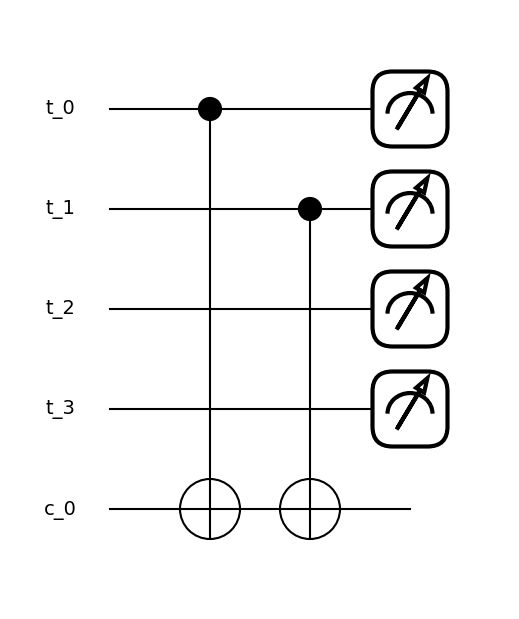

In [7]:
################
# Your Code Here
################
device = qml.device('default.qubit', wires=wires, shots=1000)

@qml.qnode(device)
def execute(circuit: Callable,
            wires: list[str],
            *args: Tuple
           ) -> np.ndarray:
    circuit(*args)
    return qml.sample(wires=wires)

################
# Your Code Here
################
circuit_arguments = (tile_qubits, clause_qubits)
qml.draw_mpl(execute)(xor, tile_qubits, *circuit_arguments)

<details>
    <summary>
        Click for solution of 1.1.4
    </summary>
    <code>device = qml.device('default.qubit', wires=wires, shots=1000)
@qml.qnode(device)
def execute(circuit: Callable,
            wires: np.ndarray,
            *args: Tuple
           ) -> np.ndarray:
    circuit(*args)
    return qml.sample(wires=wires)
circuit_arguments = (tile_qubits, clause_qubits)
qml.draw_mpl(execute)(xor, tile_qubits, *circuit_arguments)</code>
</details>

1.1.5 Apply the xor function for each clause. Print the circuit.

(<Figure size 1100x900 with 1 Axes>, <Axes: >)

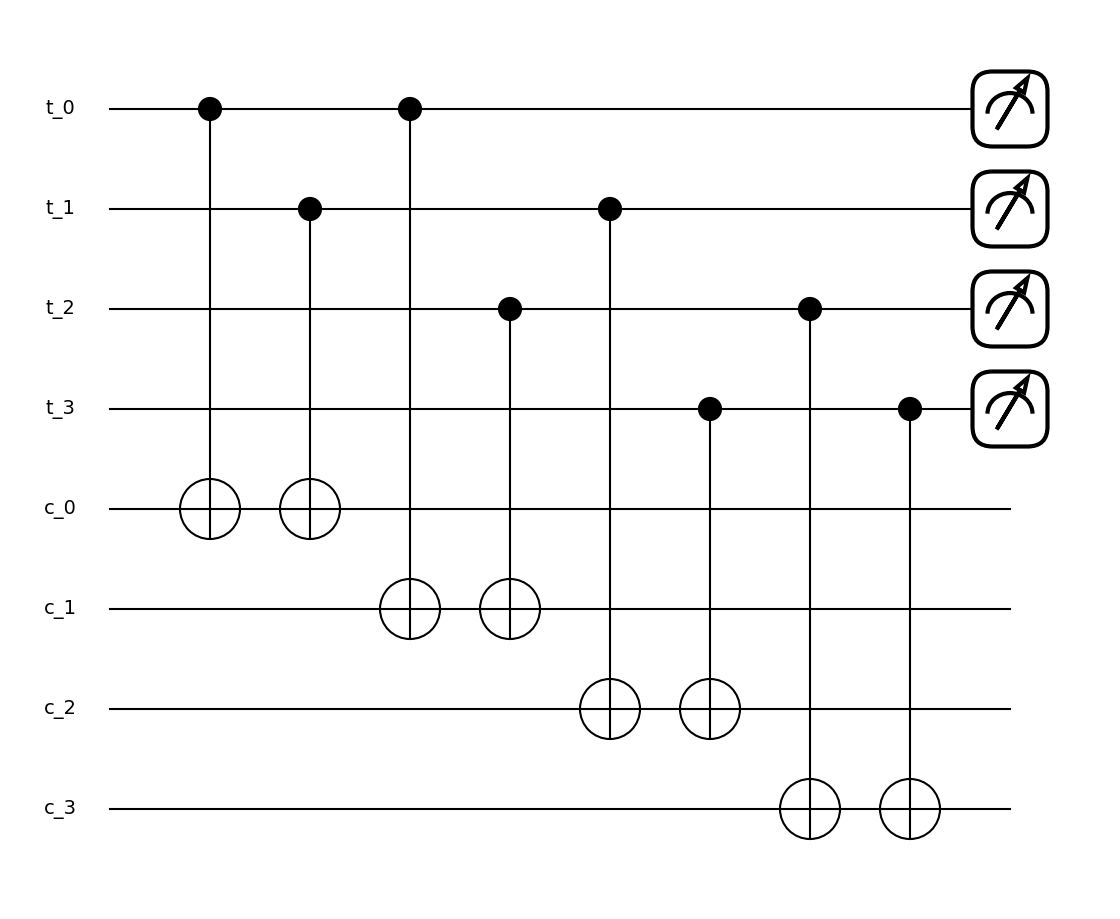

In [8]:
def clause_circuit(clause_list: list[int],
                   tile_qubits: list[str],
                   clause_qubits: list[str]
                  ) -> None:
    ################
    # Your Code Here
    ################
    i = 0
    for clause in clause_list:
        xor([tile_qubits[clause[0]],
             tile_qubits[clause[1]]],
            [clause_qubits[i]])
        i += 1

################
# Your Code Here
################
circuit_arguments = (clause_list, tile_qubits, clause_qubits)

qml.draw_mpl(execute)(clause_circuit, tile_qubits, *circuit_arguments)

<details>
    <summary>
        Click for solution of 1.1.5
    </summary>
    <code>def clause_circuit(clause_list: np.ndarray,
                   tile_qubits: np.ndarray,
                   clause_qubits: np.ndarray
                  ) -> None:
    i = 0
    for clause in clause_list:
        xor([tile_qubits[clause[0]],
             tile_qubits[clause[1]]],
            [clause_qubits[i]])
        i += 1
circuit_arguments = (clause_list, tile_qubits, clause_qubits)
qml.draw_mpl(execute)(clause_circuit, tile_qubits, *circuit_arguments)</code>
</details>

1.1.6 $\vec{t}$ is a solution only if all xor checks lead to one. Use a multicontrolled X gate controlled by the clause qubits and the result qubit as target.
Keep in mind that the clause calculation of (3) has to be undone to recreate the original state. Print this circuit $U_f$.

/home/dfki.uni-bremen.de/dheimann/Documents/pythonEnvironments/pennylane/lib/python3.10/site-packages/pennylane/ops/qubit/non_parametric_ops.py:2289: UserWarning: The control_wires keyword will be removed soon. Use wires = (control_wires, target_wire) instead. See the documentation for more information.
  warnings.warn(


(<Figure size 2000x1000 with 1 Axes>, <Axes: >)

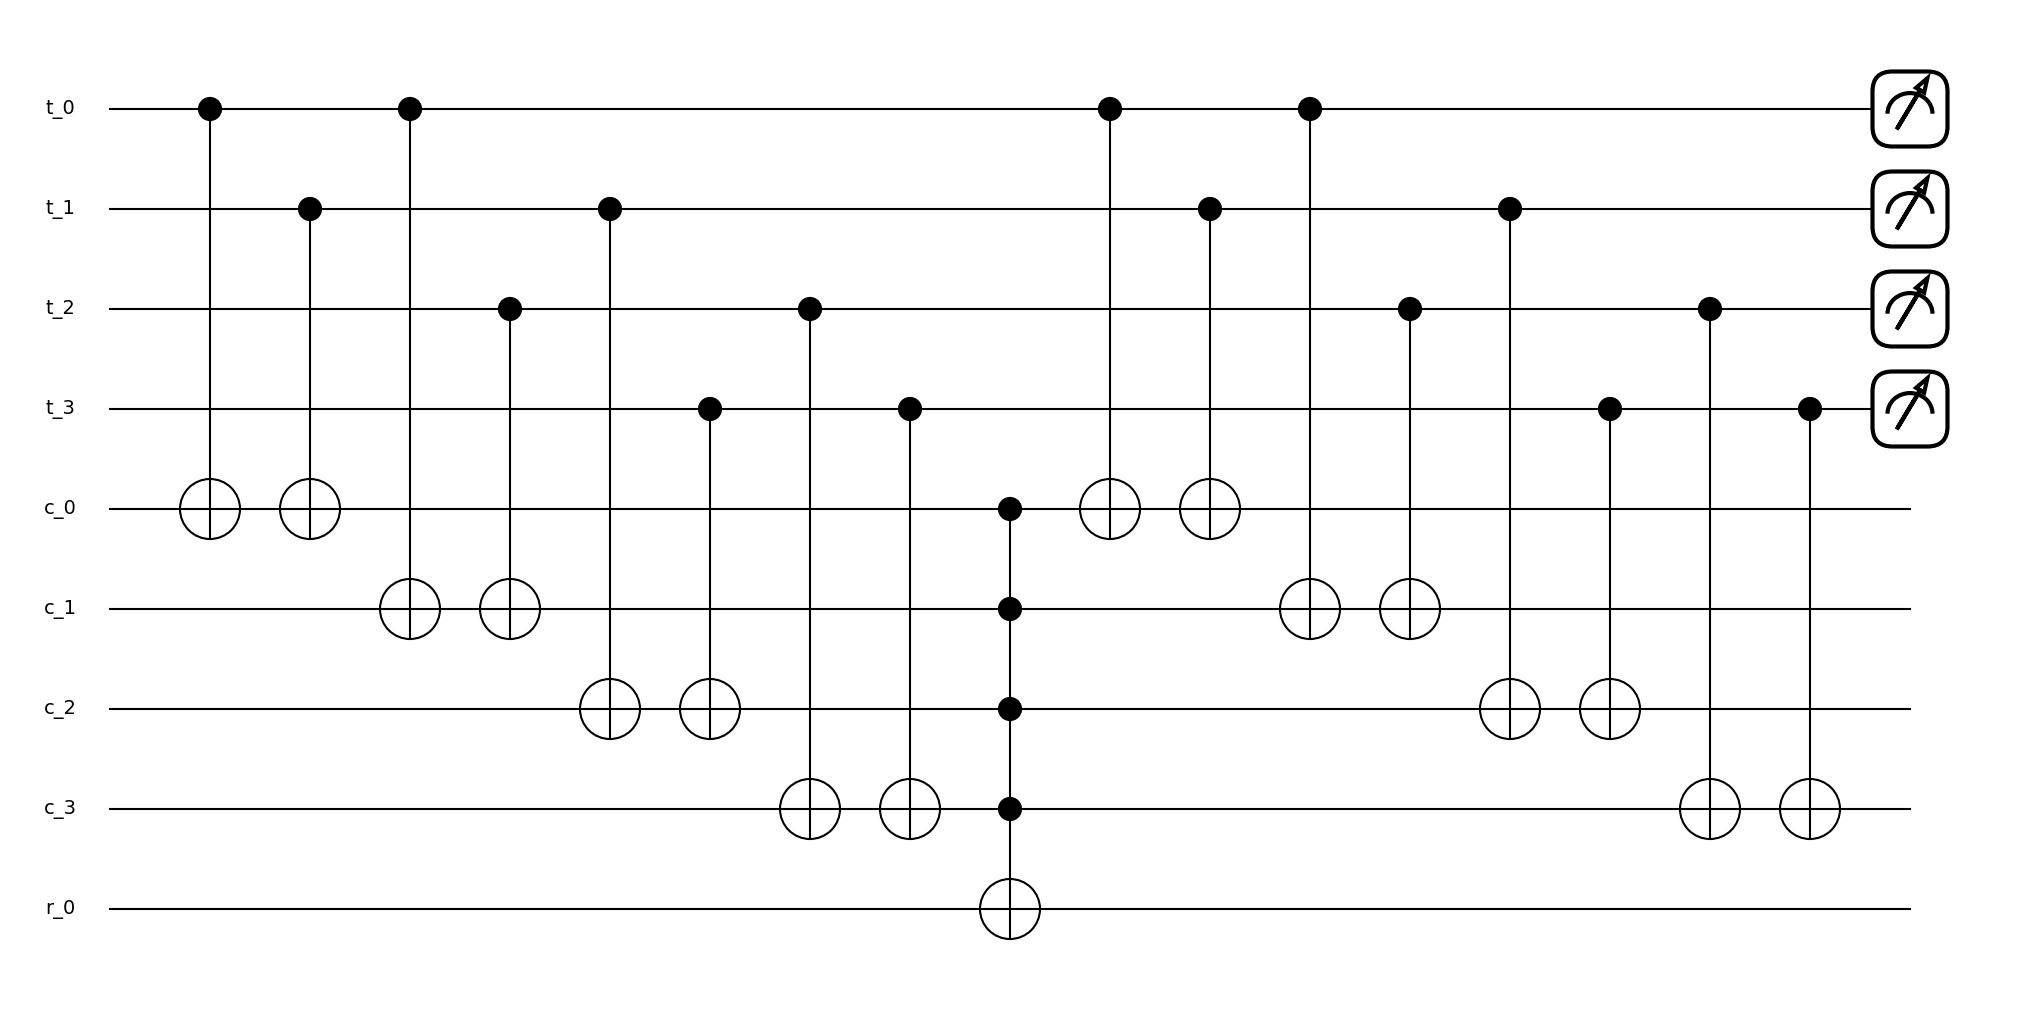

In [11]:
def oracle(clause_list: list[int],
           tile_qubits: list[str],
           clause_qubits: list[str],
           result_qubits: list[str]
          ) -> None:
    ################
    # Your Code Here
    ################
    # Compute clauses
    clause_circuit(clause_list, tile_qubits, clause_qubits)
    # Flip 'output' bit if all clauses are satisfied
    qml.MultiControlledX(clause_qubits, result_qubits)
    # Undo clauses
    clause_circuit(clause_list, tile_qubits, clause_qubits)

################
# Your Code Here
################
circuit_arguments = (clause_list, tile_qubits, clause_qubits, result_qubits)
qml.draw_mpl(execute)(oracle, tile_qubits, *circuit_arguments)

<details>
    <summary>
        Click for solution of 1.1.6
    </summary>
    <code>def oracle(clause_list: list[int],
           tile_qubits: list[str],
           clause_qubits: list[str],
           result_qubits: list[str]
          ) -> None:
    # Compute clauses
    clause_circuit(clause_list, tile_qubits, clause_qubits)
    # Flip 'output' bit if all clauses are satisfied
    qml.MultiControlledX(clause_qubits, result_qubits)
    # Undo clauses
    clause_circuit(clause_list, tile_qubits, clause_qubits)

circuit_arguments = (clause_list, tile_qubits, clause_qubits, result_qubits)
qml.draw_mpl(execute)(oracle, tile_qubits, *circuit_arguments)</code>
</details>

### 1.2 Prepare the initial state

Implment a circuit that initializes the qubits $|\vec{t}\vec{c}r\rangle$.
<ol>
  <li>All tile qubits have to be in superposition.</li>
  <li>The result qubit has to be initialized to $|r\rangle = |-\rangle$.</li>
</ol> 

In [13]:
def init_states(tile_qubits: list[str],
                result_qubits: list[str]
               ) -> None:
    ################
    # Your Code Here
    ################
    # Initialize qubits in state |s>
    for q in tile_qubits:
        qml.Hadamard(q)
        
    # Initialize 'r' in state |->    
    qml.PauliX(result_qubits[0])
    qml.Hadamard(result_qubits[0])

<details>
    <summary>
        Click for solution of 1.2
    </summary>
    <code># Initialize qubits in state |s>
    for q in tile_qubits:
        qml.Hadamard(q)
    # Initialize 'r' in state |->    
    qml.PauliX(result_qubits[0])
    qml.Hadamard(result_qubits[0])</code>
</details>

### 1.3 Grover circuit

Combine initialization, oracle and diffuser circuit and print it.

/home/dfki.uni-bremen.de/dheimann/Documents/pythonEnvironments/pennylane/lib/python3.10/site-packages/pennylane/ops/qubit/non_parametric_ops.py:2289: UserWarning: The control_wires keyword will be removed soon. Use wires = (control_wires, target_wire) instead. See the documentation for more information.
  warnings.warn(


(<Figure size 2800x1000 with 1 Axes>, <Axes: >)

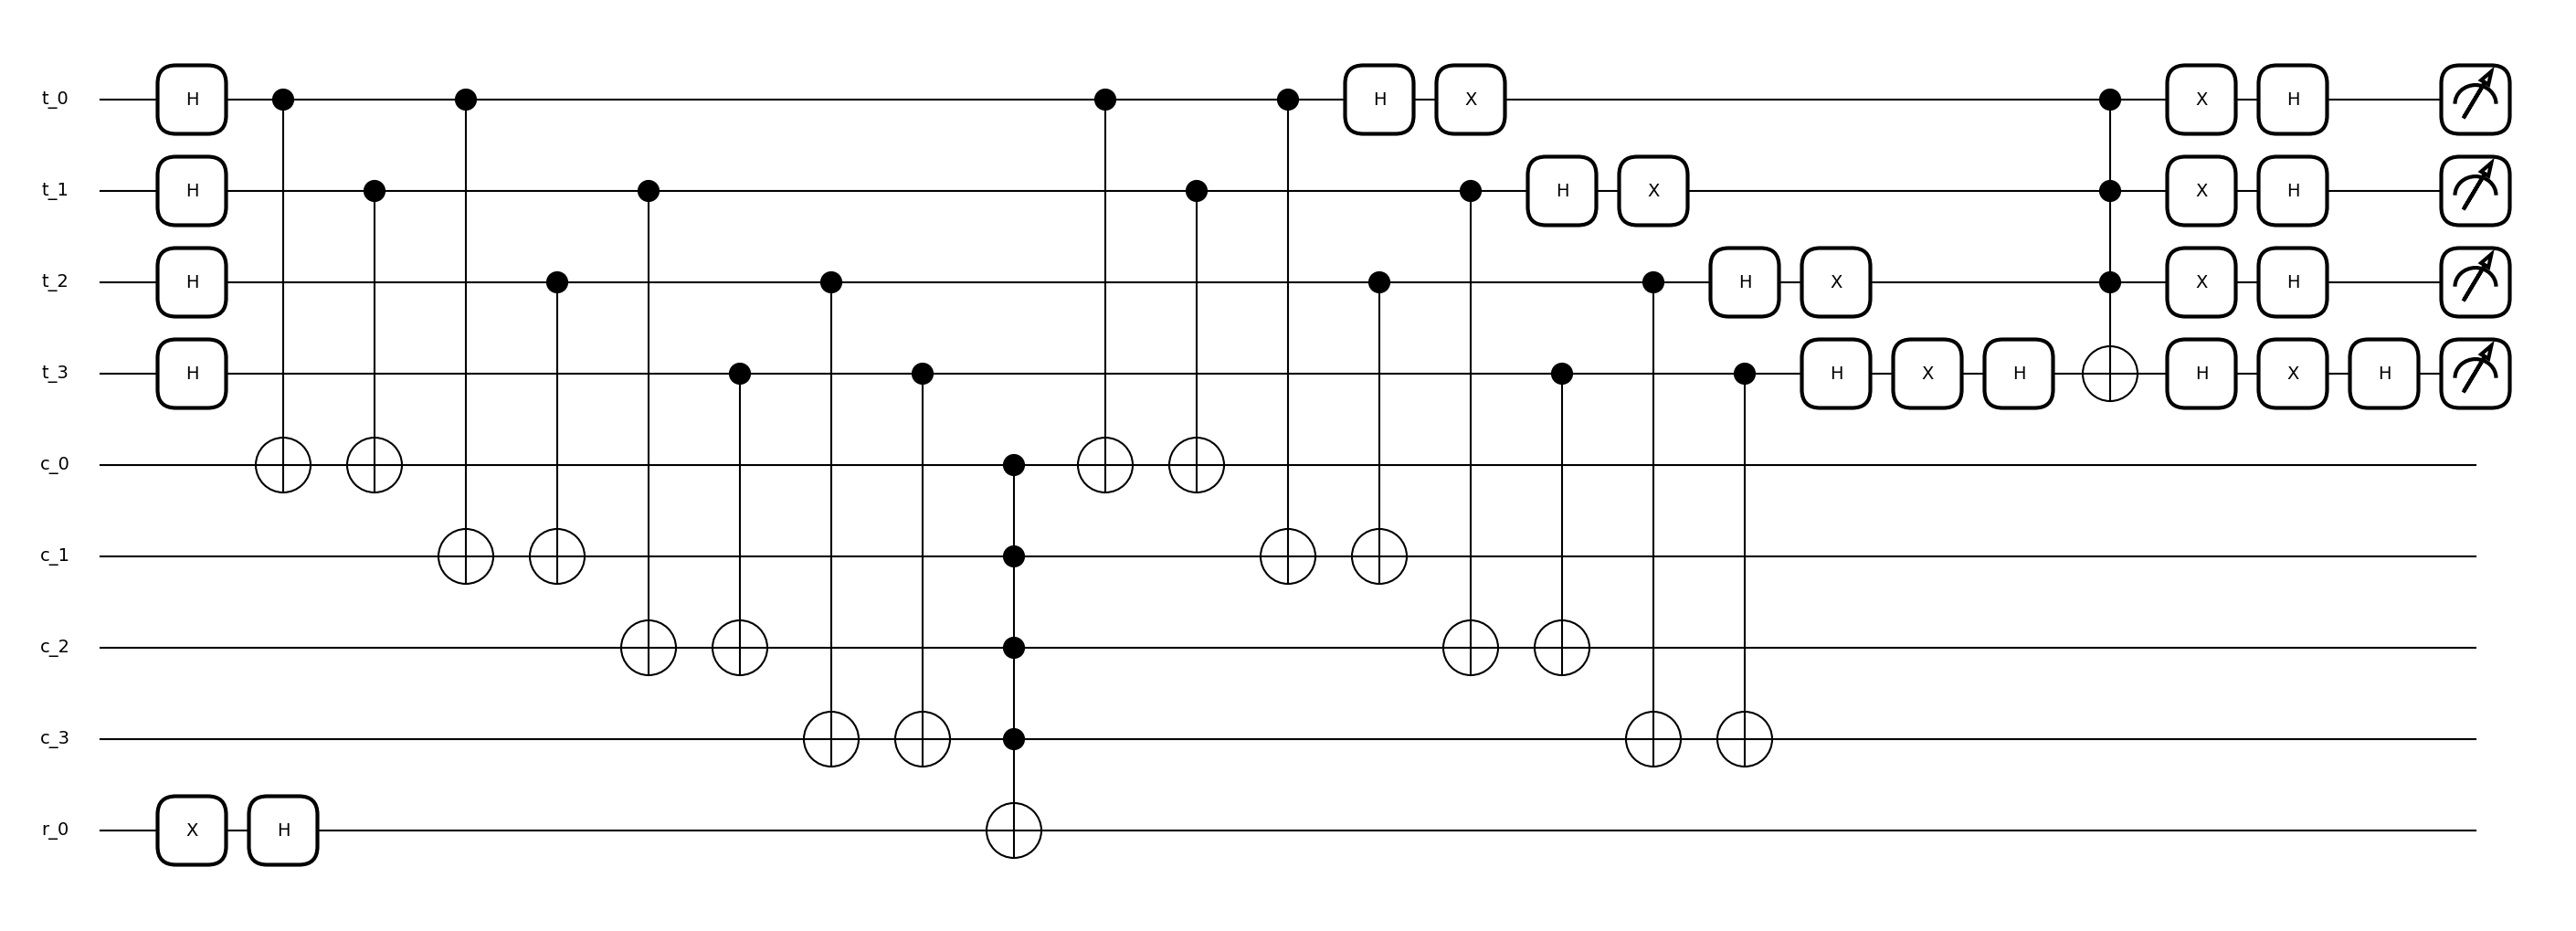

In [14]:
def grover_iteration(clause_list: list[int],
                     tile_qubits: list[str],
                     clause_qubits: list[str],
                     result_qubits: list[str]
                    ) -> None:
    ################
    # Your Code Here
    ################
    # Apply our oracle
    oracle(clause_list, tile_qubits, clause_qubits, result_qubits)
    
    # Apply our diffuser
    diffuser(tile_qubits)
    
def grover(clause_list: list[int],
           tile_qubits: list[str],
           clause_qubits: list[str],
           result_qubits: list[str]
          ) -> None:
    ################
    # Your Code Here
    ################
    # Initialization
    init_states(tile_qubits, result_qubits)
    # One Iteration
    grover_iteration(clause_list, tile_qubits, clause_qubits, result_qubits)

################
# Your Code Here
################
circuit_arguments = (clause_list, tile_qubits, clause_qubits, result_qubits)
qml.draw_mpl(execute)(grover, tile_qubits, *circuit_arguments)

<details>
    <summary>
        Click for solution of 1.3
    </summary>
    <code>def grover_iteration(clause_list: list[int],
                     tile_qubits: list[str],
                     clause_qubits: list[str],
                     result_qubits: list[str]
                    ) -> None:
    # Apply our oracle
    oracle(clause_list, tile_qubits, clause_qubits, result_qubits)
    # Apply our diffuser
    diffuser(tile_qubits)
    
def grover(clause_list: list[int],
           tile_qubits: list[str],
           clause_qubits: list[str],
           result_qubits: list[str]
          ) -> None:
    # Initialization
    init_states(tile_qubits, result_qubits)
    # One Iteration
    grover_iteration(clause_list, tile_qubits, clause_qubits, result_qubits)

circuit_arguments = (clause_list, tile_qubits, clause_qubits, result_qubits)
qml.draw_mpl(execute)(grover, tile_qubits, *circuit_arguments)</code>
</details>

### 1.4 Simulate results

Execute the Grover algorithm and plot the histogram. You may use the function `sample_histogram()` that we provide to plot the samples result.

/home/dfki.uni-bremen.de/dheimann/Documents/pythonEnvironments/pennylane/lib/python3.10/site-packages/pennylane/ops/qubit/non_parametric_ops.py:2289: UserWarning: The control_wires keyword will be removed soon. Use wires = (control_wires, target_wire) instead. See the documentation for more information.
  warnings.warn(


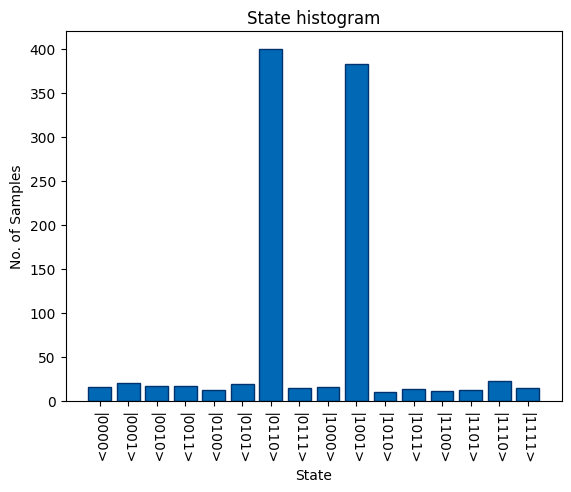

In [15]:
################
# Your Code Here
################
samples = execute(grover, tile_qubits, *circuit_arguments)
sample_histogram(np.atleast_2d(samples))

<details>
    <summary>
        Click for solution of 1.4
    </summary>
    <code>
samples = execute(grover, tile_qubits, *circuit_arguments)
sample_histogram(np.atleast_2d(samples))</code>
</details>

The correct solutions $|0110\rangle$ and $|1001\rangle$ should appeare roughly $350$ times each. All other states appear much less frequent (approximatly $<50$).

## Task 2: 2X3 grid

With the solution for the small [grid_4](./img/grid_4.pdf) with four tiles,
we can alter the example slightly to get more familiar with the code.
Let us consider the 6 tiles [grid_6](./img/grid_6.pdf).
The task remains the same: label the tiles such that neighbouring tiles at edges are not allowed to have the same number. Only diagonal tiles are allowed to have the same number.
Still, the example is easy and it has exactly two solutions. However, it will hopefully help to get more familiar with the code of how to implement the oracle.

Alter the code of Task 1 such that Grover's algorithm finds the two solutions for the [grid_6](./img/grid_6.pdf). To do so, change the clause list (which will impact the orcale) and the number of qubits. You also may want to use `print_sorted_samples()` to see the five states that occured most often.  

In [ ]:
################
# Your Code Here
################

<details>
    <summary>
        Click two see the two correct solutions.
    </summary>
    The correct solutions to the 6 tiles example are $|011001\rangle$ and $|100110\rangle$. Both sould appear around $100$ times if one Grover iteration step is used.
</details>

In [16]:
n_states = 6
clause_list = [
    [0,1],
    [0,2],
    [1,3],
    [2,3],
    [2,4],
    [3,5],
    [4,5]
]

In [17]:
n_clauses = len(clause_list)

# Create separate registers to name bits
tile_qubits = ['t_' + str(s) for s in range(n_states)]
clause_qubits = ['c_'+str(c) for c in range(len(clause_list))]
result_qubits = ['o_0']
wires = flatten_list([tile_qubits, clause_qubits, result_qubits])

/home/dfki.uni-bremen.de/dheimann/Documents/pythonEnvironments/pennylane/lib/python3.10/site-packages/pennylane/ops/qubit/non_parametric_ops.py:2289: UserWarning: The control_wires keyword will be removed soon. Use wires = (control_wires, target_wire) instead. See the documentation for more information.
  warnings.warn(


|100110> :  138
|011001> :  120
|111111> :  22
|110011> :  21
|010110> :  21


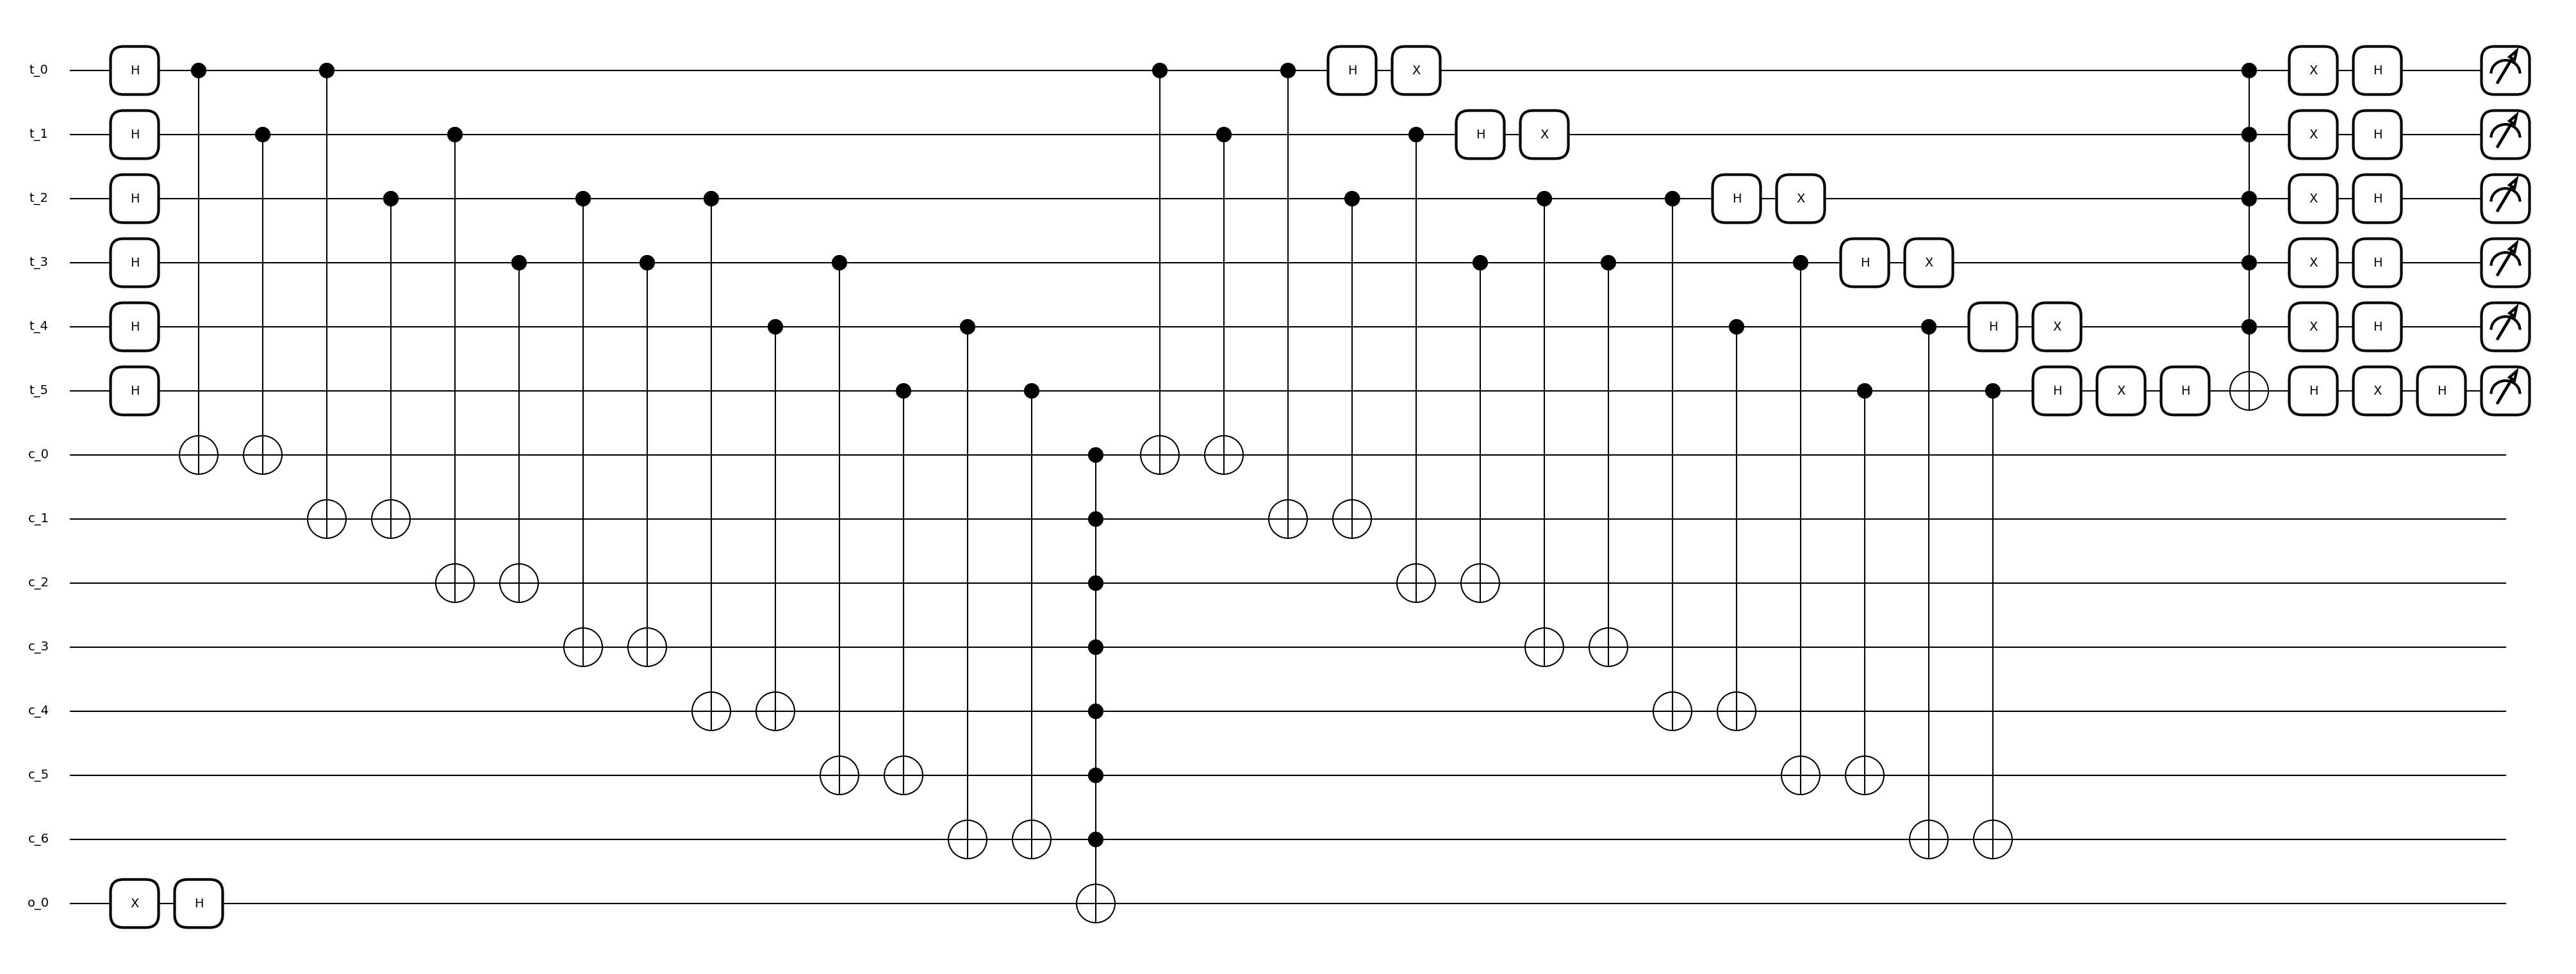

In [18]:
device = qml.device('default.qubit', wires=wires, shots=1000)
@qml.qnode(device)
def execute(circuit, wires, *args):
    circuit(*args)
    return qml.sample(wires=wires)

circuit_arguments = (clause_list, tile_qubits, clause_qubits, result_qubits)
qml.draw_mpl(execute)(grover, tile_qubits, *circuit_arguments)

samples = execute(grover, tile_qubits, *circuit_arguments)
samples_sorted = print_sorted_samples(samples)

# Task 3: How many Grover steps are necessary?

We can express the probabilty of getting one of the correct solutions by the following formula
$$ P(\text{success}) = \sin^2\Bigl[ (2R+1)\arccos \bigl( \sqrt{\frac{N-M}{N}} \bigr) \Bigr] $$

derived in the section "Optimal number of iterations" of the [microsoft textbook](https://learn.microsoft.com/en-us/azure/quantum/concepts-grovers)
with $R$ the number of iteration steps, $N$ the number of possible states and $M$ the number of solutions.
Please, note that $N=2^n$ with $n$ the number tiles in our toy example.

How many iteration steps are necessary to optain the solutions with almost 100% probability?
$$ R_{\text{opt}} = \frac{\pi}{4} \sqrt{\frac{N}{M}} - \frac{1}{2} - O(\frac{M}{N})$$
Derive this fact from the first equation by using $\sin^2(\frac{\pi}{2} ) = 1 $ and $\arccos(1-x) = \sqrt{x} + O(x)$.

How many iteration steps are necessary to optain the solutions with almost 50% probability?
$$ R_{\text{0.5}} = \frac{\pi}{8} \sqrt{\frac{N}{M}} - \frac{1}{2} - O(\frac{M}{N})$$
Derive this fact from the first equation by using $\sin^2(\frac{\pi}{4} ) = 0.5 $ and $\arccos(1-x) = \sqrt{x} + O(x)$.

We can use both equations to calculate the necessary iteration steps:

| Iteration steps $R$ | $(n=4, M=2)$ | $(n=6, M=2)$ | $(n=8, M=2)$ |
|---------------------|:------------:|:------------:|:------------:|
| $R_{0.5}$           | $0.6$        | $1.7$        |$3.9$         |
| $R_{\text{opt}}$    | $1.7$        | $3.9$        |$8.4$         |

Optional: Verify these numbers by analytic calculation.

By using the first equation, we obtain the following table:

| Iteration steps $R$ | Probabilty P(success) | Probabilty P(success) | Probabilty P(success) |
|---------------------|:---------------------:|:---------------------:|:---------------------:|
|                     | $(n=4, M=2)$          | $(n=6, M=2)$          | $(n=8, M=2)$          |
| 1                   | $78.1 \%$             | $25.8 \%$             | $6.9 \%$              |
| 2                   | $94.5 \%$             | $60.2 \%$             | $18.3 \%$             |
| 3                   | $\ldots$              | $89.7 \%$             | $33.7 \%$             |
| 4                   | $\ldots$              | $99.9 \%$             | $51.1 \%$             |
| $\vdots$            | $\vdots$              | $\vdots$              | $\vdots$              |
| 8                   | $\ldots$              | $\ldots$              | $99.6 \%$             |

Verify these numbers (optional: by analytic calculation) by implementing each configuration and checking the probabilty for obtaining the correct solution.
The grids are defined as in [grid_4](./img/grid_4.pdf), [grid_6](./img/grid_6.pdf) and [grid_8](./img/grid_8.pdf) with the same rules which means that all have exactly two solutions. You may want to use `print_sorted_samples()` to see the five states that occured most often.  

In [19]:
def get_clauses(n_states):
    '''
    Function to define rules for sudoku with 2 columns and n_states/2 rows.
    '''
    clause_list = []
    if n_states%2==1: raise ValueError('Rules only defined for an even number of tiles.')
    for state in range(n_states-1):
        if state % 2 ==0:
            clause_list.append([state,state+1])

        if state != n_states -2: clause_list.append([state,state+2])
    return clause_list

In [21]:
def grover_steps(clause_list, tile_qubits, clause_qubits, result_qubits, iteration_steps):

    # Initialization
    init_states(tile_qubits, result_qubits)

    ## Create more iterations
    for _ in range(iteration_steps):
        grover_iteration(clause_list, tile_qubits, clause_qubits, result_qubits)

6 tiles, 4 Grover iteration steps


/home/dfki.uni-bremen.de/dheimann/Documents/pythonEnvironments/pennylane/lib/python3.10/site-packages/pennylane/ops/qubit/non_parametric_ops.py:2289: UserWarning: The control_wires keyword will be removed soon. Use wires = (control_wires, target_wire) instead. See the documentation for more information.
  warnings.warn(


|011001> :  501
|100110> :  499
with success probabilty: 100.0 %


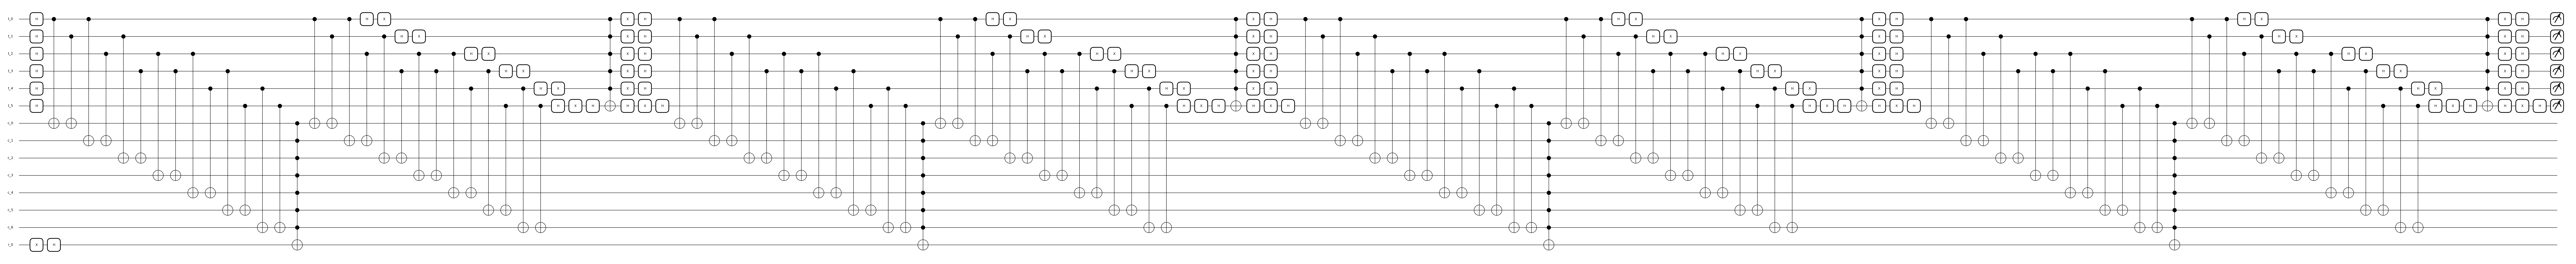

In [22]:
### Define toy example
draw_circuit = True # True: draw circuit
M = 2 # always only two solutions possible
shots = 1000


n_states = 6 #[4,6,8]
iteration_steps = 4 #[[1,2], [1,2,3,4], [1,2,3,4,8]]

print(n_states, "tiles,", iteration_steps, "Grover iteration steps")
clause_list = get_clauses(n_states)
n_clauses = len(clause_list)

# Create separate registers to name bits
tile_qubits = ['t_' + str(s) for s in range(n_states)]
clause_qubits = ['c_'+str(c) for c in range(n_clauses)]
result_qubits = ['r_0']
wires = flatten_list([tile_qubits, clause_qubits, result_qubits])

device = qml.device('default.qubit', wires=wires, shots=shots)
@qml.qnode(device)
def execute(circuit, wires, *args):
    circuit(*args)
    return qml.sample(wires=wires)

circuit_arguments = (clause_list, tile_qubits, clause_qubits, result_qubits, iteration_steps)
if draw_circuit: qml.draw_mpl(execute)(grover_steps, tile_qubits, *circuit_arguments)

samples = execute(grover_steps, tile_qubits, *circuit_arguments)
samples_sorted = print_sorted_samples(samples)
print("with success probabilty:", round(sum(samples_sorted[1][:M])/shots*100, 3), "%")